# Análise de Research Questions

## Detecção de Code Smells com Sistema Multi-Agentes baseado em LLM

**Modelo:** Claude Sonnet 4.5

### Research Questions:
- **RQ1:** Qual a eficácia do sistema multi-agentes na detecção de code smells?
- **RQ2:** Qual o impacto da qualidade dos prompts na performance?
- **RQ3:** Como o sistema se compara com análise estática tradicional (DPy)?
- **RQ4:** Qual a performance individual de cada agente especializado?
- **RQ5:** Qual o custo-benefício operacional do sistema?

In [55]:
import json
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
from IPython.display import Image, display
from scipy import stats

warnings.filterwarnings("ignore")

BASE_DIR = Path().resolve().parent
RESULTS_DIR = BASE_DIR / "results"
DATASET_DIR = BASE_DIR / "dataset"
FIGURES_DIR = RESULTS_DIR / "figures"

INPUT_PRICE_PER_M = 3.00
OUTPUT_PRICE_PER_M = 15.00

print(f"Diretório: {BASE_DIR}")

Diretório: /home/luis-chaves/Área de trabalho/tcc/multi-agent-smell-detector


In [56]:
gt = pd.read_csv(DATASET_DIR / "ground_truth" / "ground_truth_corrected.csv")
ma_complete = pd.read_csv(RESULTS_DIR / "csv" / "results_with_complete_prompts.csv")
ma_simple = pd.read_csv(RESULTS_DIR / "csv" / "results_simple_prompt.csv")
dpy = pd.read_csv(RESULTS_DIR / "dpy" / "dataset_implementation_smells.csv")

with open(RESULTS_DIR / "json" / "token_usage_complete_prompts.json") as f:
    tokens_complete = json.load(f)
with open(RESULTS_DIR / "json" / "token_usage_simple_prompt.json") as f:
    tokens_simple = json.load(f)


def normalize_smell(smell):
    return smell.lower().strip() if pd.notna(smell) else "unknown"


def extract_filename(path):
    return Path(str(path)).name if pd.notna(path) else ""


for df, col in [
    (gt, "Code_Smell"),
    (ma_complete, "Code_Smell"),
    (ma_simple, "Code_Smell"),
    (dpy, "Smell"),
]:
    df["smell_normalized"] = df[col].apply(normalize_smell)
    df["file_name"] = df["File"].apply(extract_filename)

print(f"Ground Truth: {len(gt)} entradas")
print(f"Multi-agentes (Elaborados): {len(ma_complete)} detecções")
print(f"Multi-agentes (Simples): {len(ma_simple)} detecções")
print(f"DPy: {len(dpy)} detecções")

Ground Truth: 397 entradas
Multi-agentes (Elaborados): 432 detecções
Multi-agentes (Simples): 563 detecções
DPy: 385 detecções


In [57]:
def calculate_metrics(detections_df, gt_df):
    matched_gt, matched_det = set(), set()
    for det_idx, det in detections_df.iterrows():
        for gt_idx, gt_row in gt_df.iterrows():
            if gt_idx in matched_gt:
                continue
            if (
                det["file_name"] == gt_row["file_name"]
                and det["smell_normalized"] == gt_row["smell_normalized"]
            ):
                matched_gt.add(gt_idx)
                matched_det.add(det_idx)
                break
    tp = len(matched_det)
    fp = len(detections_df) - tp
    fn = len(gt_df) - len(matched_gt)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (
        2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    )
    return {
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
    }


metrics_complete = calculate_metrics(ma_complete, gt)
metrics_simple = calculate_metrics(ma_simple, gt)
metrics_dpy = calculate_metrics(dpy, gt)

## RQ1: Performance Geral

Tabela 1: Comparação de Performance


,Abordagem,Detecções,TP,FP,FN,Precision,Recall,F1-Score
0,Multi-agentes (Elaborados),432,291,141,106,67.36%,73.30%,70.21%
1,Multi-agentes (Simples),563,322,241,75,57.19%,81.11%,67.08%
2,DPy (Estático),385,190,195,207,49.35%,47.86%,48.59%



Figura 1:


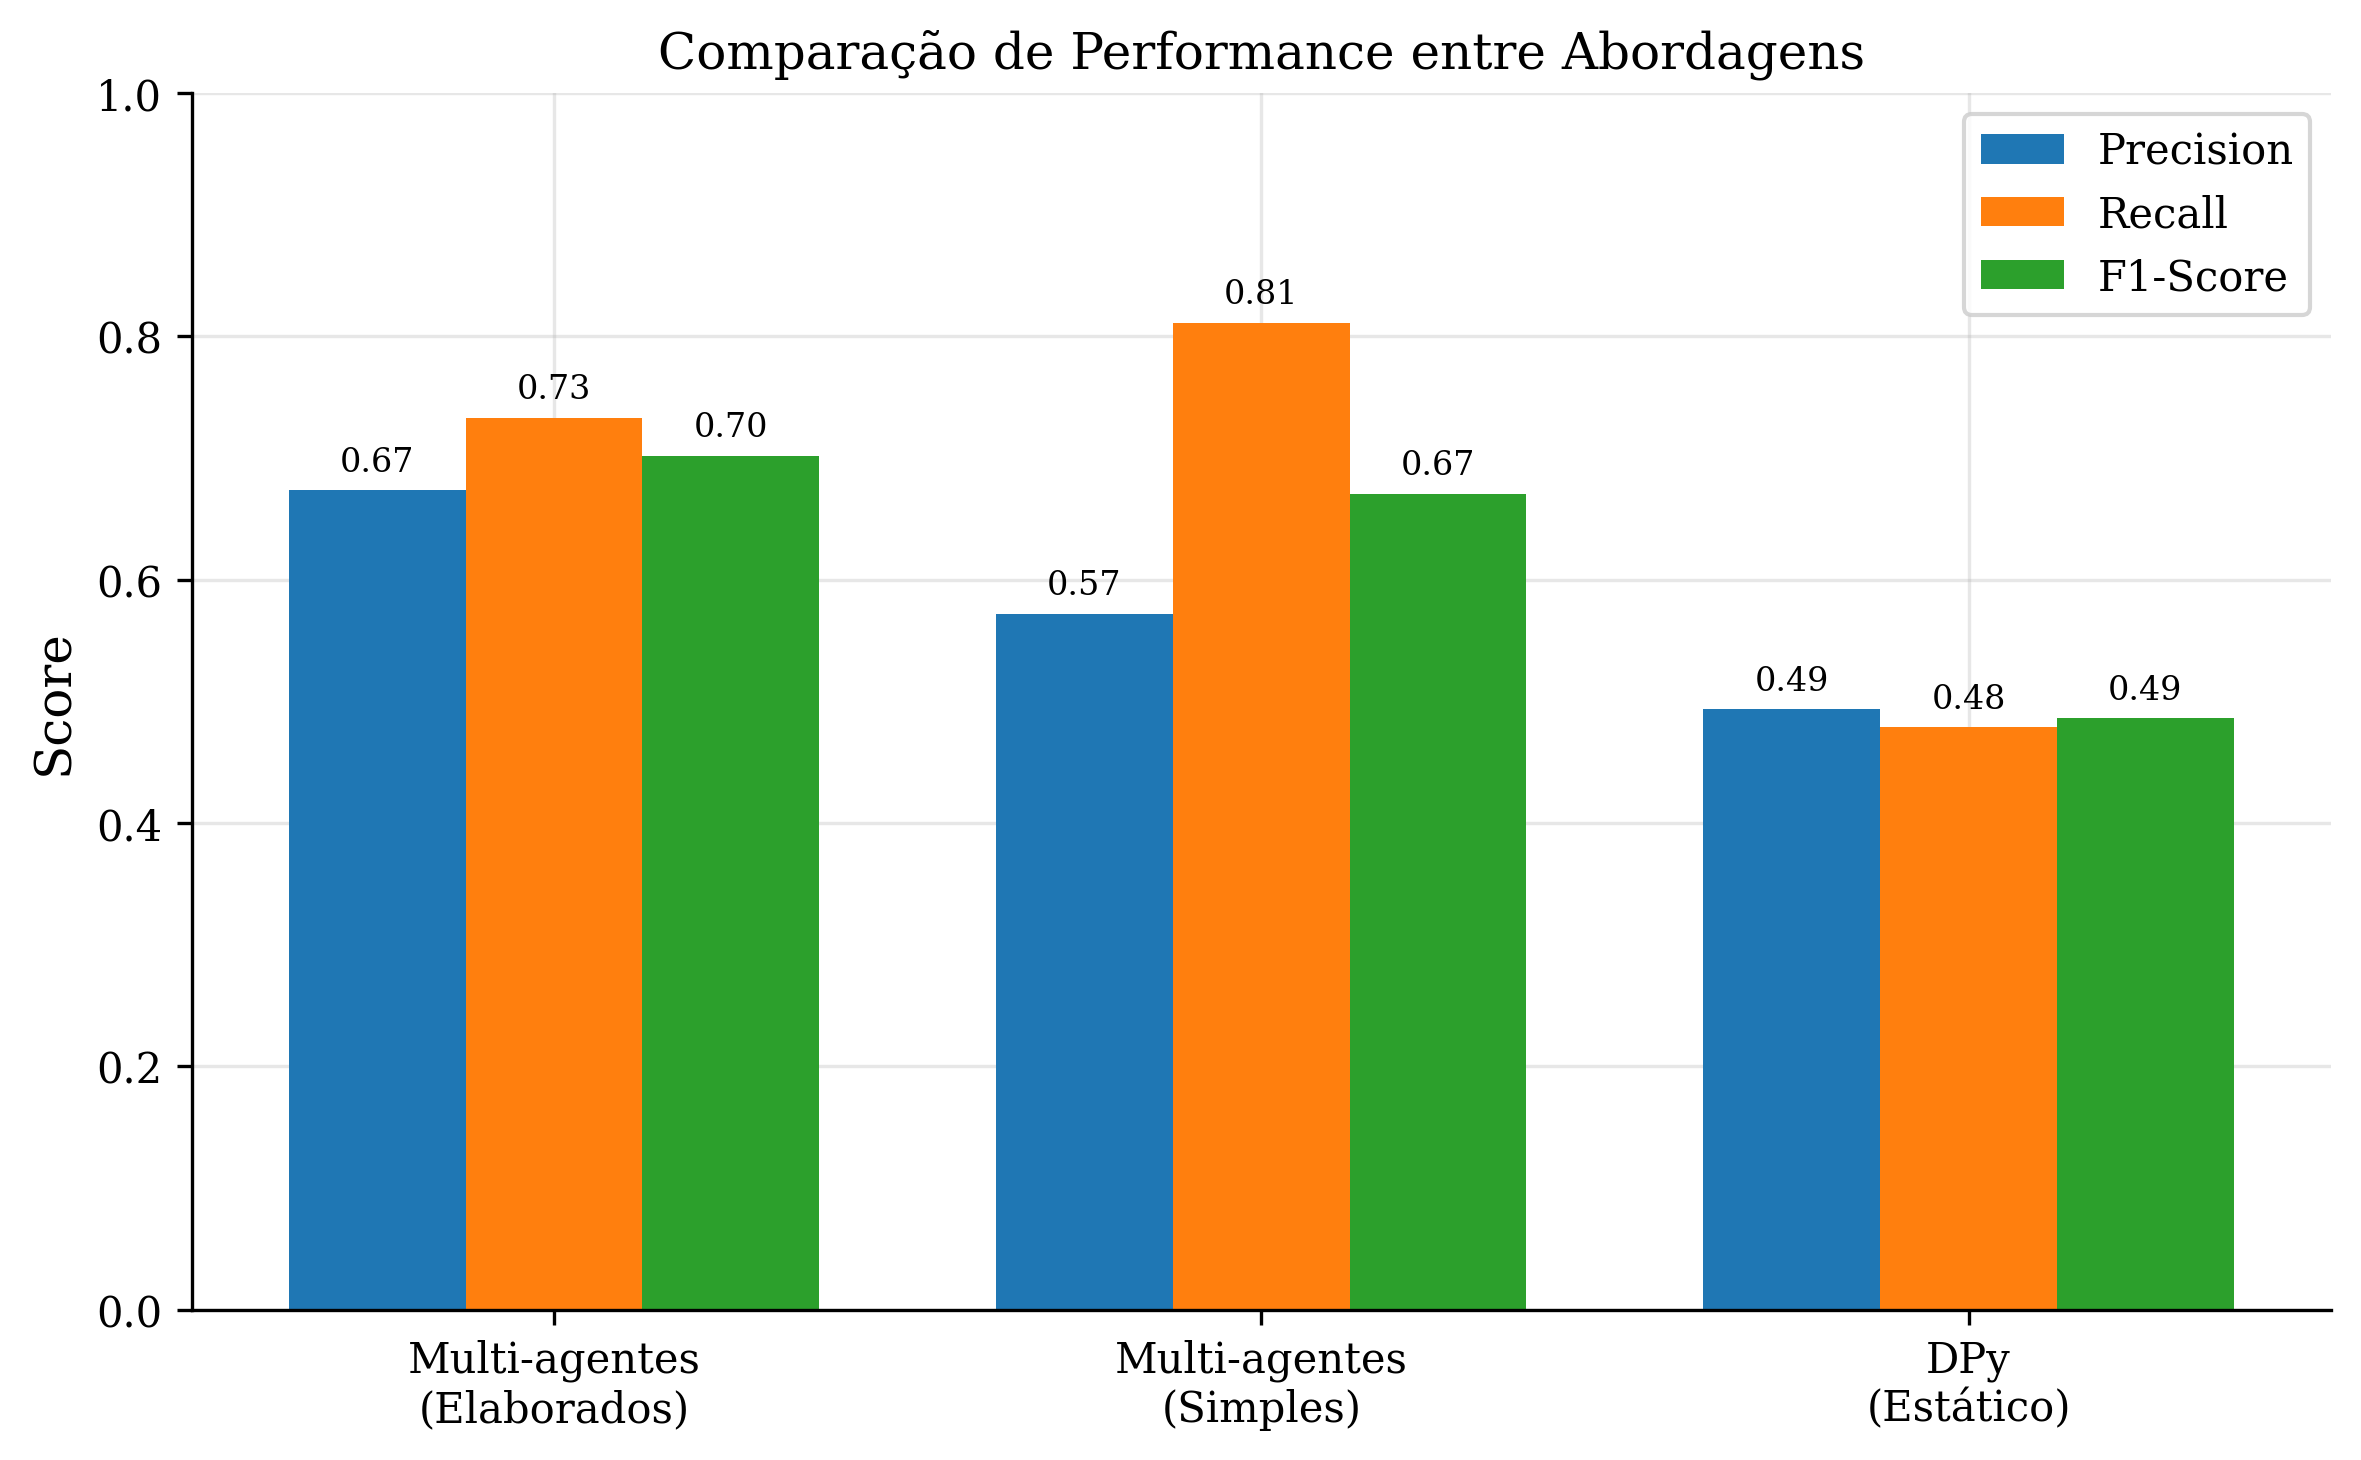

In [58]:
results_df = pd.DataFrame(
    {
        "Abordagem": [
            "Multi-agentes (Elaborados)",
            "Multi-agentes (Simples)",
            "DPy (Estático)",
        ],
        "Detecções": [len(ma_complete), len(ma_simple), len(dpy)],
        "TP": [metrics_complete["TP"], metrics_simple["TP"], metrics_dpy["TP"]],
        "FP": [metrics_complete["FP"], metrics_simple["FP"], metrics_dpy["FP"]],
        "FN": [metrics_complete["FN"], metrics_simple["FN"], metrics_dpy["FN"]],
        "Precision": [
            f"{metrics_complete['Precision']:.2%}",
            f"{metrics_simple['Precision']:.2%}",
            f"{metrics_dpy['Precision']:.2%}",
        ],
        "Recall": [
            f"{metrics_complete['Recall']:.2%}",
            f"{metrics_simple['Recall']:.2%}",
            f"{metrics_dpy['Recall']:.2%}",
        ],
        "F1-Score": [
            f"{metrics_complete['F1']:.2%}",
            f"{metrics_simple['F1']:.2%}",
            f"{metrics_dpy['F1']:.2%}",
        ],
    }
)
print("Tabela 1: Comparação de Performance")
display(results_df)
print("\nFigura 1:")
display(Image(FIGURES_DIR / "fig1_comparison_metrics.png"))

## RQ2: Impacto dos Prompts

Tabela 2: Impacto da Qualidade dos Prompts

Métrica                   Elaborados         Simples       Diferença
-----------------------------------------------------------------
Precision                     67.36%          57.19%          +10.2pp
Recall                        73.30%          81.11%           -7.8pp
F1-Score                      70.21%          67.08%           +3.1pp

Teste Chi-quadrado: χ² = 10.26, p-valor = 0.0014

Figura 2:


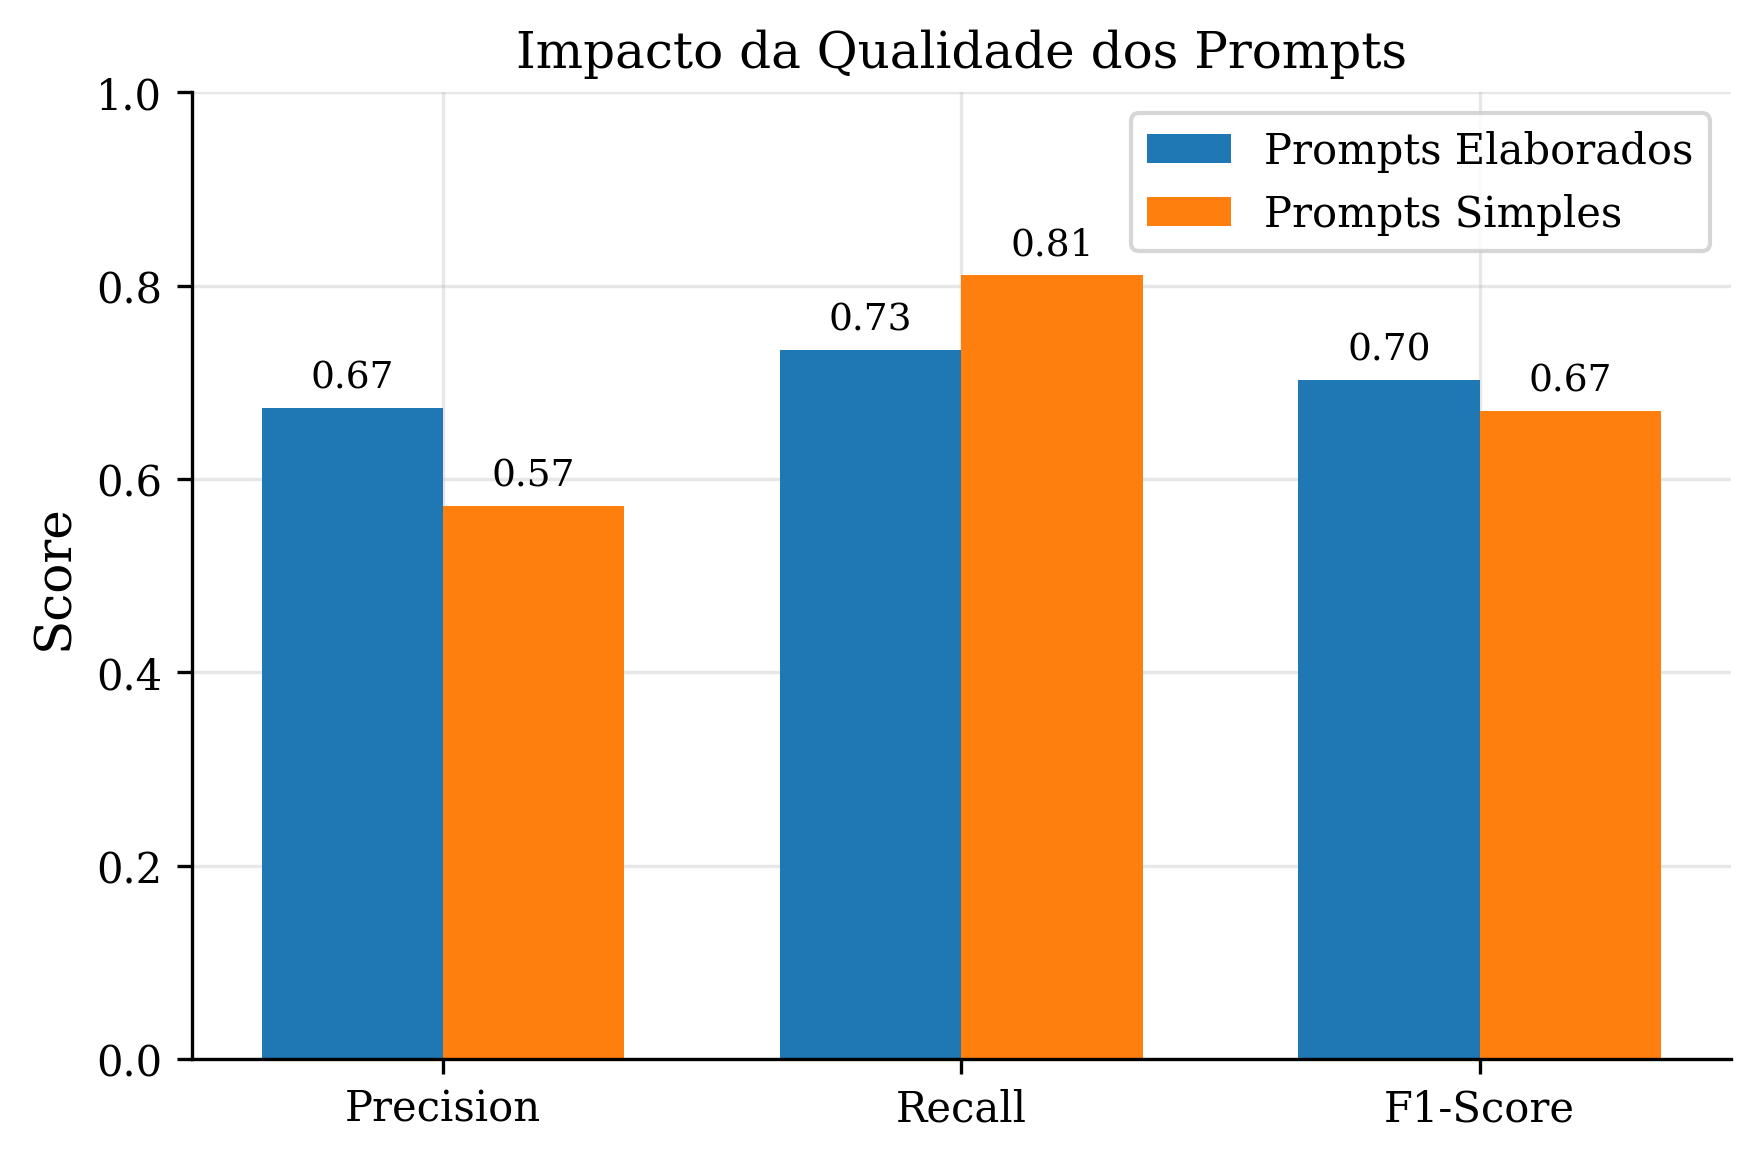

In [59]:
print("Tabela 2: Impacto da Qualidade dos Prompts\n")
print(f"{'Métrica':<20} {'Elaborados':>15} {'Simples':>15} {'Diferença':>15}")
print("-" * 65)
print(
    f"{'Precision':<20} {metrics_complete['Precision']:>15.2%} {metrics_simple['Precision']:>15.2%} {(metrics_complete['Precision'] - metrics_simple['Precision']) * 100:>+14.1f}pp"
)
print(
    f"{'Recall':<20} {metrics_complete['Recall']:>15.2%} {metrics_simple['Recall']:>15.2%} {(metrics_complete['Recall'] - metrics_simple['Recall']) * 100:>+14.1f}pp"
)
print(
    f"{'F1-Score':<20} {metrics_complete['F1']:>15.2%} {metrics_simple['F1']:>15.2%} {(metrics_complete['F1'] - metrics_simple['F1']) * 100:>+14.1f}pp"
)
contingency = np.array(
    [
        [metrics_complete["TP"], metrics_complete["FP"]],
        [metrics_simple["TP"], metrics_simple["FP"]],
    ]
)
chi2, p_value, _, _ = stats.chi2_contingency(contingency)
print(f"\nTeste Chi-quadrado: χ² = {chi2:.2f}, p-valor = {p_value:.4f}")
print("\nFigura 2:")
display(Image(FIGURES_DIR / "fig2_prompt_impact.png"))

## RQ3: Comparação com DPy

Tabela 3: Multi-agentes vs DPy

Métrica                Multi-agentes             DPy       Diferença
-----------------------------------------------------------------
F1-Score                      70.21%          48.59%          +21.6pp
Precision                     67.36%          49.35%          +18.0pp
Recall                        73.30%          47.86%          +25.4pp

Figura 3:


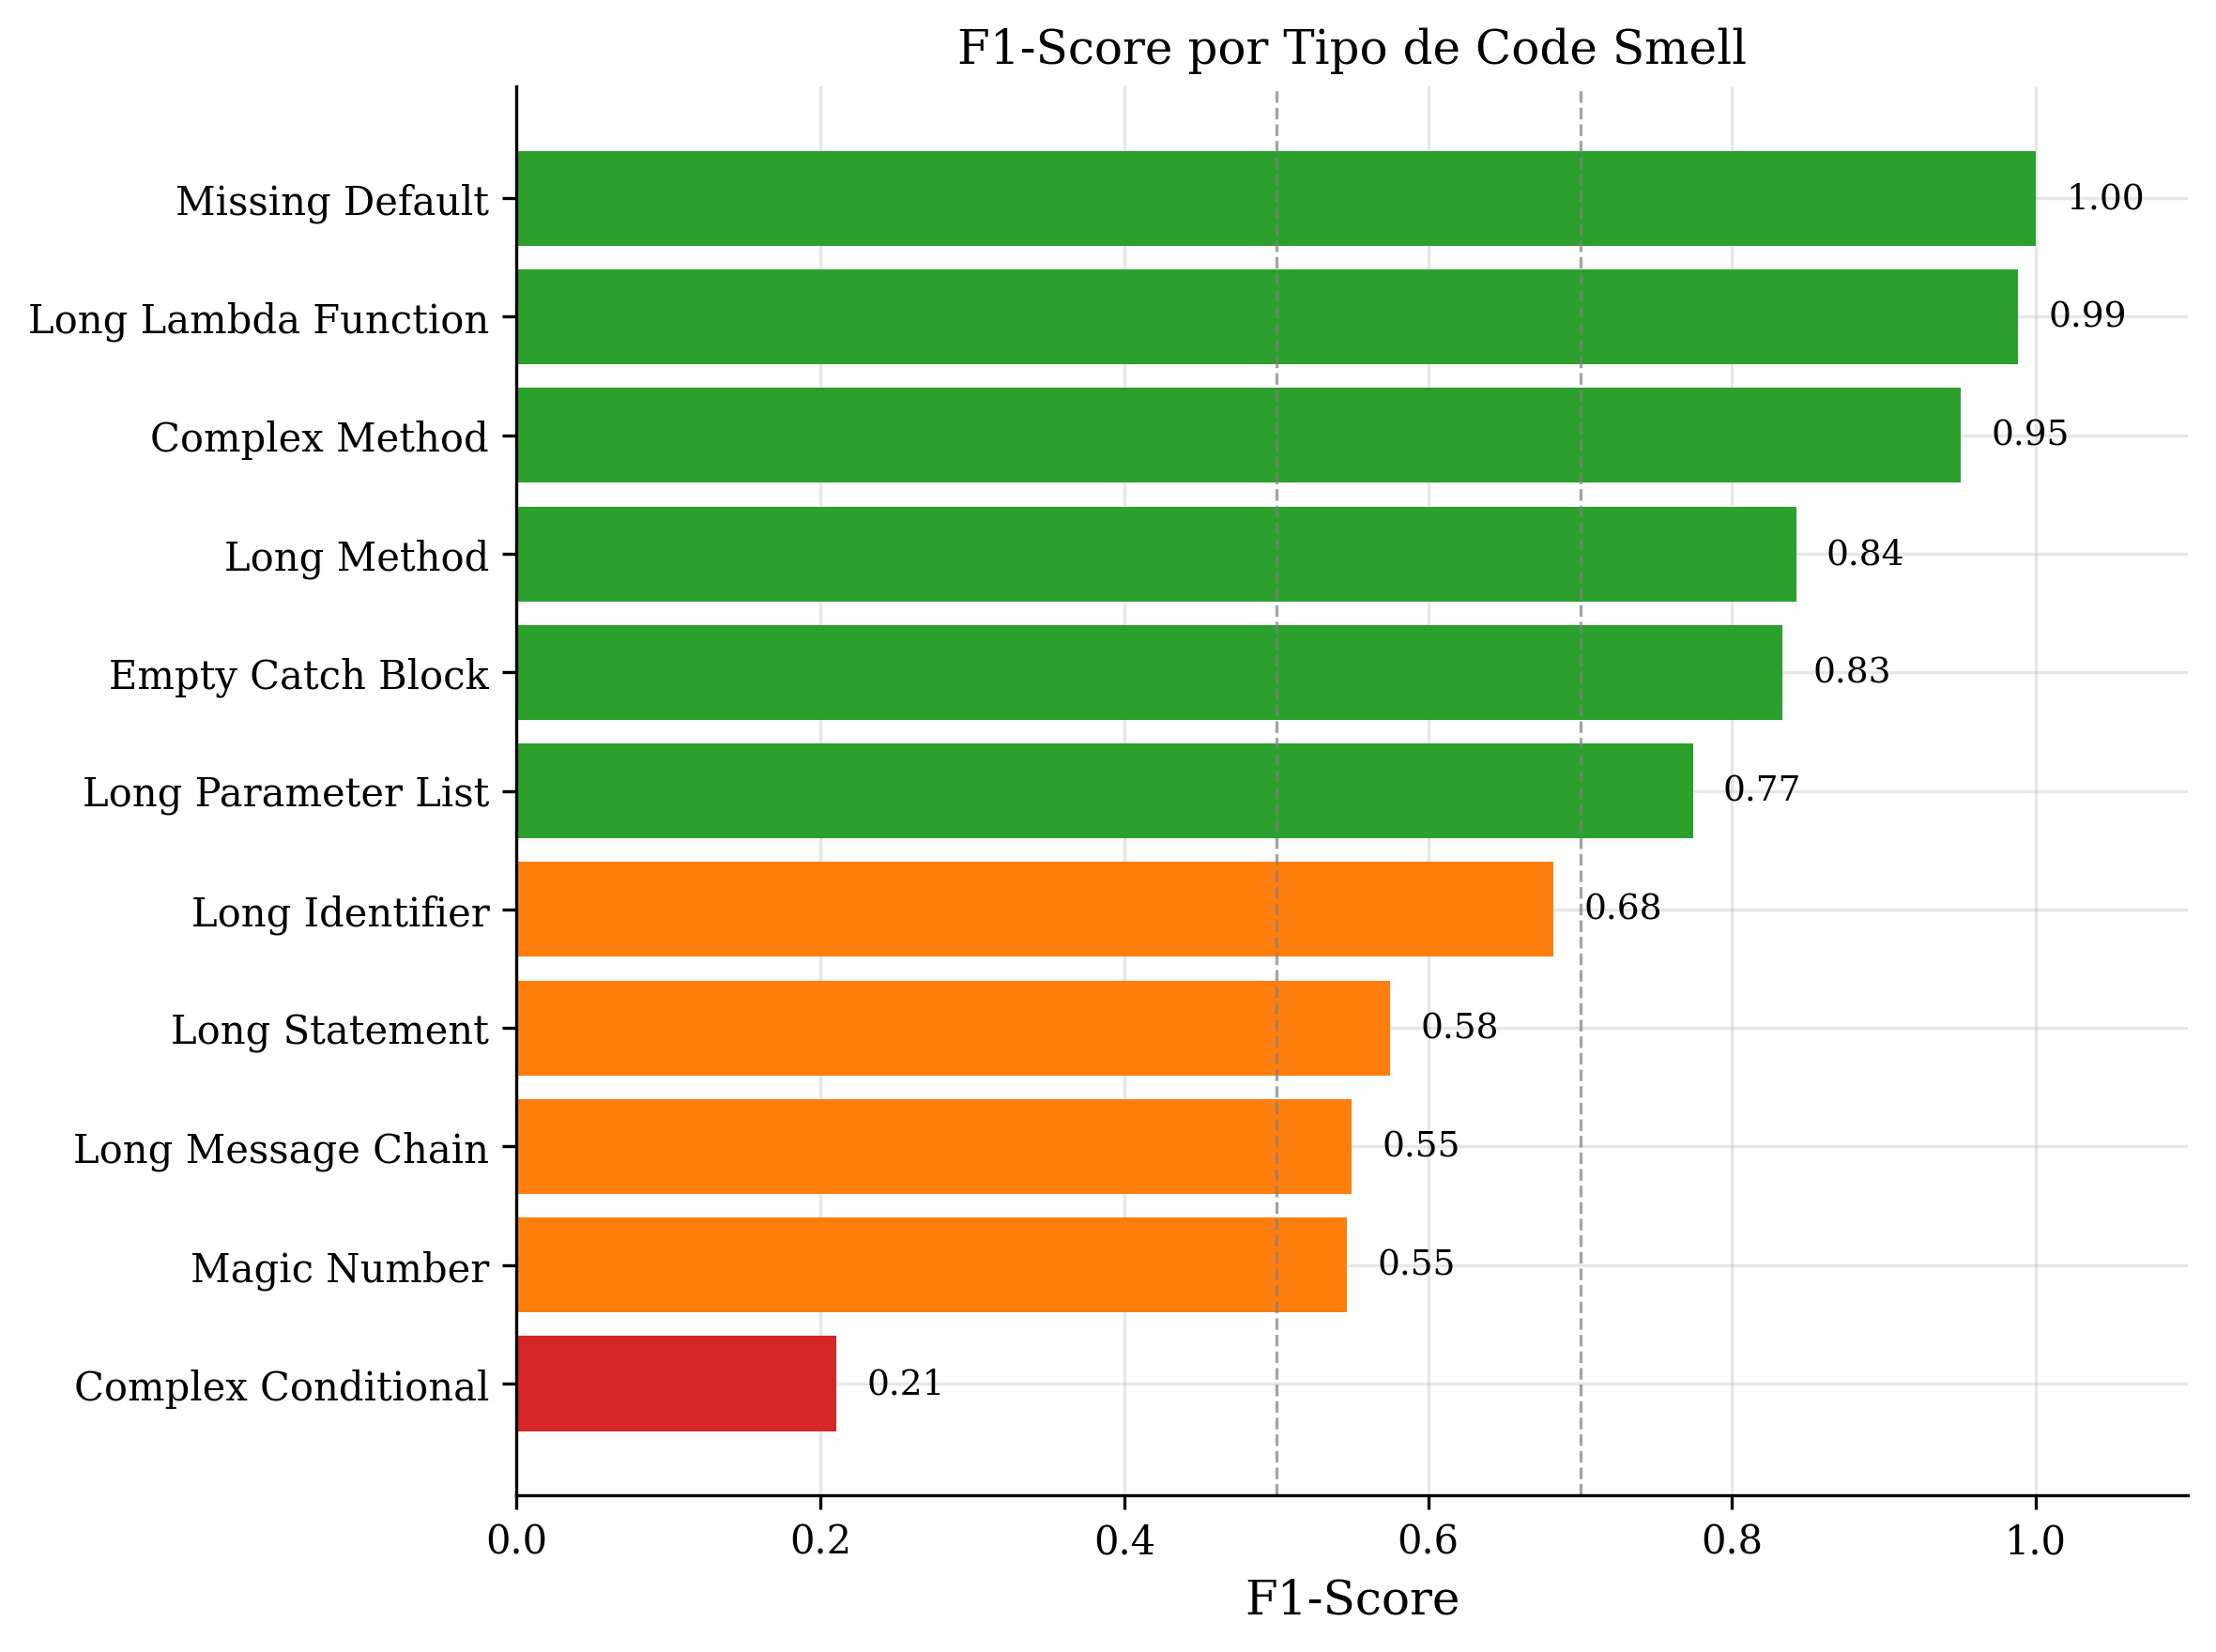

In [60]:
print("Tabela 3: Multi-agentes vs DPy\n")
print(f"{'Métrica':<20} {'Multi-agentes':>15} {'DPy':>15} {'Diferença':>15}")
print("-" * 65)
print(
    f"{'F1-Score':<20} {metrics_complete['F1']:>15.2%} {metrics_dpy['F1']:>15.2%} {(metrics_complete['F1'] - metrics_dpy['F1']) * 100:>+14.1f}pp"
)
print(
    f"{'Precision':<20} {metrics_complete['Precision']:>15.2%} {metrics_dpy['Precision']:>15.2%} {(metrics_complete['Precision'] - metrics_dpy['Precision']) * 100:>+14.1f}pp"
)
print(
    f"{'Recall':<20} {metrics_complete['Recall']:>15.2%} {metrics_dpy['Recall']:>15.2%} {(metrics_complete['Recall'] - metrics_dpy['Recall']) * 100:>+14.1f}pp"
)
print("\nFigura 3:")
display(Image(FIGURES_DIR / "fig3_f1_by_smell.png"))

## RQ4: Performance dos Agentes

Tabela 4: Performance por Tipo de Smell



,Smell,GT,Det,TP,Precision,Recall,F1
9,Missing Default,1,1,1,100.0%,100.0%,100.0%
3,Long Lambda Function,43,42,42,100.0%,97.7%,98.8%
1,Complex Method,53,48,48,100.0%,90.6%,95.0%
5,Long Method,40,36,32,88.9%,80.0%,84.2%
10,Empty Catch Block,19,17,15,88.2%,78.9%,83.3%
6,Long Parameter List,12,19,12,63.2%,100.0%,77.4%
2,Long Identifier,35,50,29,58.0%,82.9%,68.2%
7,Long Statement,79,74,44,59.5%,55.7%,57.5%
4,Long Message Chain,38,53,25,47.2%,65.8%,54.9%
8,Magic Number,71,79,41,51.9%,57.7%,54.7%



Figura 4:


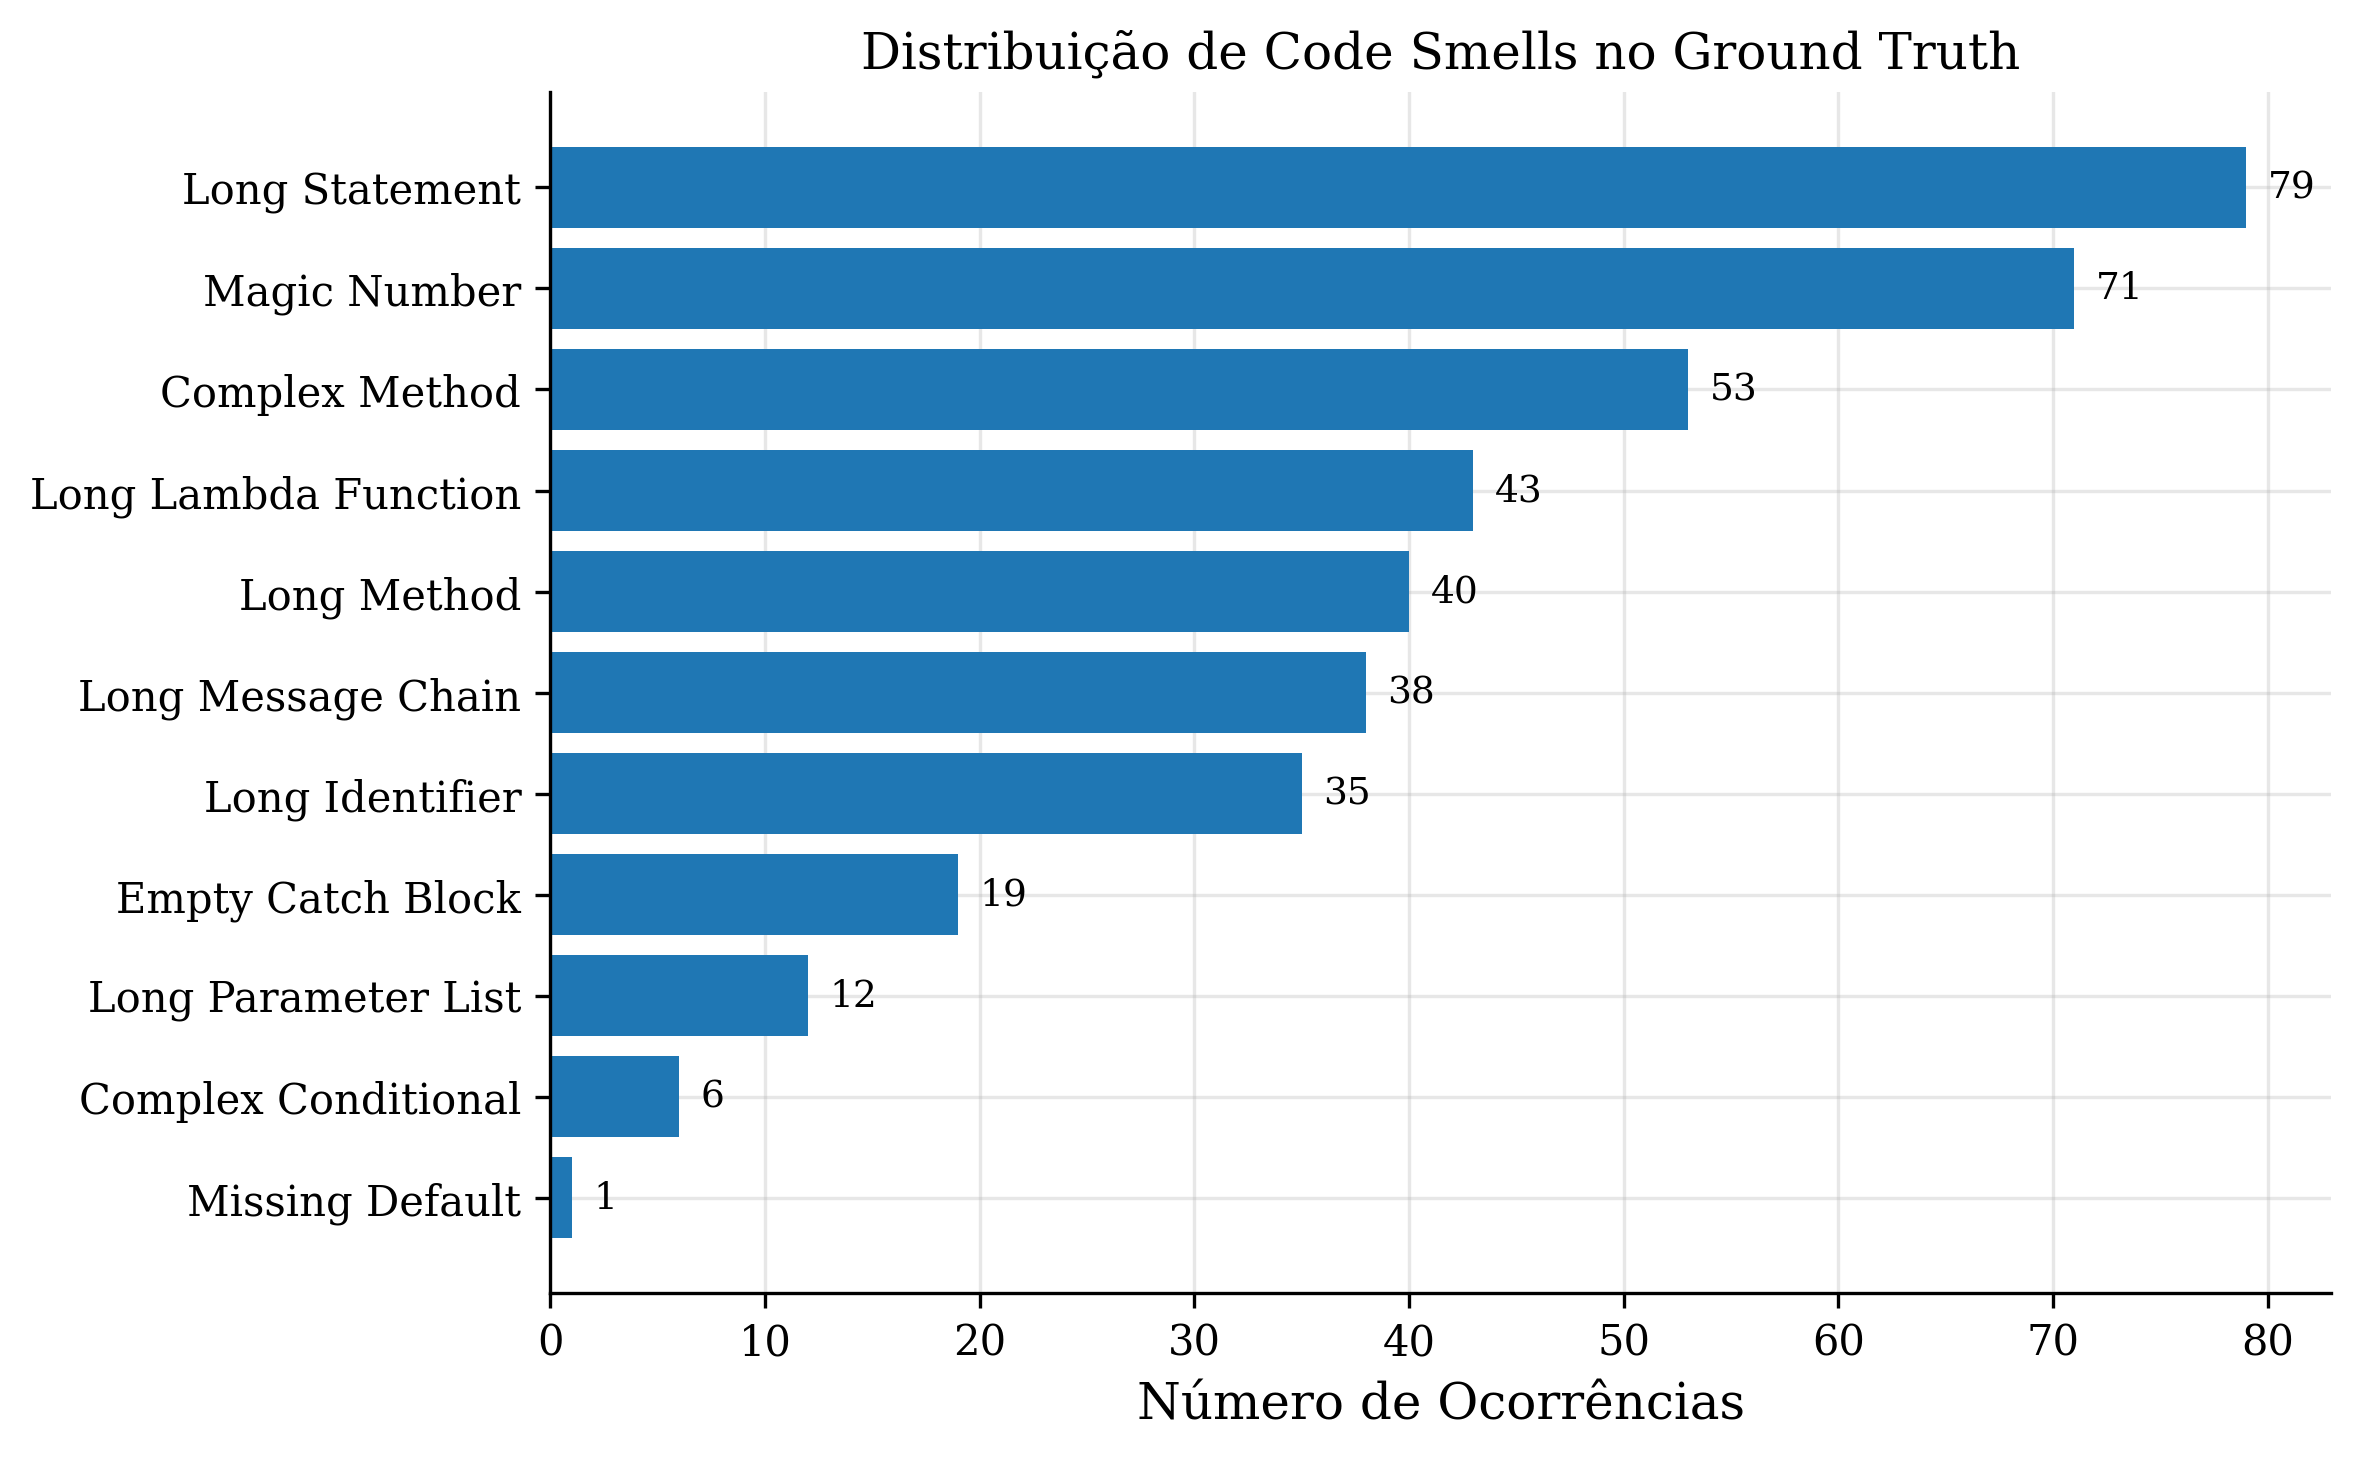

In [61]:
def metrics_by_smell(detections_df, gt_df):
    results = []
    for smell in gt_df["smell_normalized"].unique():
        det = detections_df[detections_df["smell_normalized"] == smell]
        gt_smell = gt_df[gt_df["smell_normalized"] == smell]
        if len(gt_smell) == 0:
            continue
        m = calculate_metrics(det, gt_smell)
        results.append(
            {
                "Smell": smell.title(),
                "GT": len(gt_smell),
                "Det": len(det),
                "TP": m["TP"],
                "Precision": m["Precision"],
                "Recall": m["Recall"],
                "F1": m["F1"],
            }
        )
    return pd.DataFrame(results).sort_values("F1", ascending=False)


smell_df = metrics_by_smell(ma_complete, gt)
print("Tabela 4: Performance por Tipo de Smell\n")
smell_display = smell_df.copy()
smell_display["Precision"] = smell_display["Precision"].apply(lambda x: f"{x:.1%}")
smell_display["Recall"] = smell_display["Recall"].apply(lambda x: f"{x:.1%}")
smell_display["F1"] = smell_display["F1"].apply(lambda x: f"{x:.1%}")
display(smell_display)
print("\nFigura 4:")
display(Image(FIGURES_DIR / "fig4_smell_distribution.png"))

## RQ5: Custos

Tabela 5: Análise de Custos (Claude Sonnet 4.5)

Métrica                        Elaborados         Simples
-------------------------------------------------------
Total Tokens                    1,710,813       1,648,896
Custo Total               $        5.7925 $        5.7743

Figura 5:


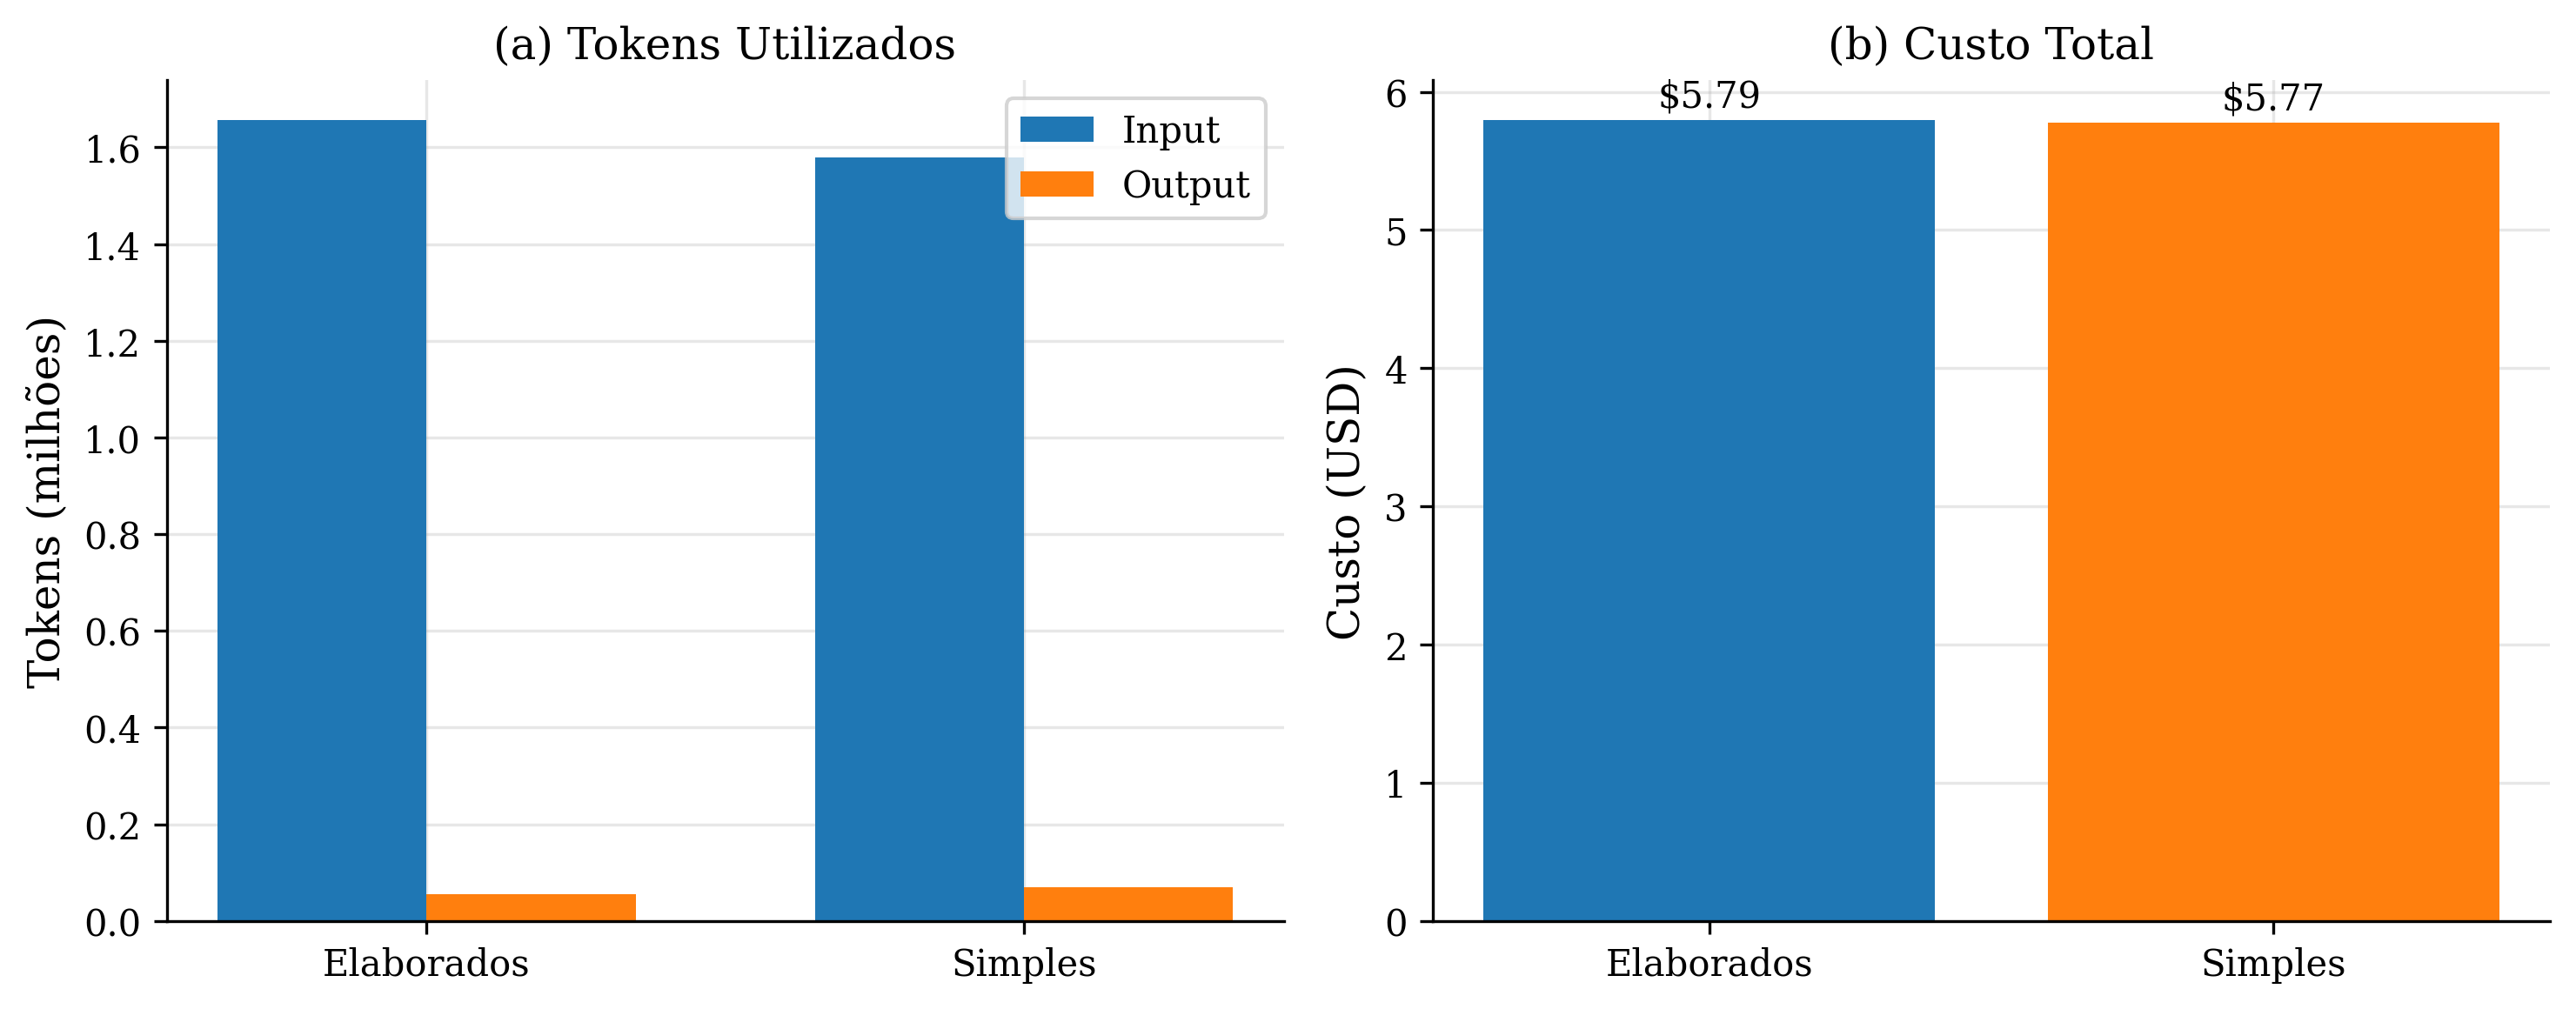

In [62]:
prompt_tokens = tokens_complete.get("token_usage", {}).get("prompt_tokens", 0)
completion_tokens = tokens_complete.get("token_usage", {}).get("completion_tokens", 0)
total_tokens = tokens_complete.get("token_usage", {}).get("total_tokens", 0)
prompt_tokens_simple = tokens_simple.get("token_usage", {}).get("prompt_tokens", 0)
completion_tokens_simple = tokens_simple.get("token_usage", {}).get(
    "completion_tokens", 0
)
total_tokens_simple = tokens_simple.get("token_usage", {}).get("total_tokens", 0)

input_cost = (prompt_tokens / 1_000_000) * INPUT_PRICE_PER_M
output_cost = (completion_tokens / 1_000_000) * OUTPUT_PRICE_PER_M
total_cost = input_cost + output_cost
input_cost_simple = (prompt_tokens_simple / 1_000_000) * INPUT_PRICE_PER_M
output_cost_simple = (completion_tokens_simple / 1_000_000) * OUTPUT_PRICE_PER_M
total_cost_simple = input_cost_simple + output_cost_simple

print("Tabela 5: Análise de Custos (Claude Sonnet 4.5)\n")
print(f"{'Métrica':<25} {'Elaborados':>15} {'Simples':>15}")
print("-" * 55)
print(f"{'Total Tokens':<25} {total_tokens:>15,} {total_tokens_simple:>15,}")
print(f"{'Custo Total':<25} ${total_cost:>14.4f} ${total_cost_simple:>14.4f}")
print("\nFigura 5:")
display(Image(FIGURES_DIR / "fig6_cost_analysis.png"))

## Resumo

In [63]:
print("=" * 60)
print("RESUMO EXECUTIVO")
print("=" * 60)
print(
    f"""\nRQ1: F1-Score = {metrics_complete["F1"]:.2%}\nRQ2: Elaborados ({metrics_complete["F1"]:.2%}) vs Simples ({metrics_simple["F1"]:.2%})\nRQ3: Multi-agentes ({metrics_complete["F1"]:.2%}) vs DPy ({metrics_dpy["F1"]:.2%})\nRQ4: Melhor = {smell_df.iloc[0]["Smell"]} ({smell_df.iloc[0]["F1"]:.2%})\nRQ5: Custo Total = ${total_cost:.4f}"""
)
print("\n" + "=" * 60)

RESUMO EXECUTIVO

RQ1: F1-Score = 70.21%
RQ2: Elaborados (70.21%) vs Simples (67.08%)
RQ3: Multi-agentes (70.21%) vs DPy (48.59%)
RQ4: Melhor = Missing Default (100.00%)
RQ5: Custo Total = $5.7925

